In [1]:
import scipy.stats as sts
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy.special as sp
from scipy.optimize import minimize 

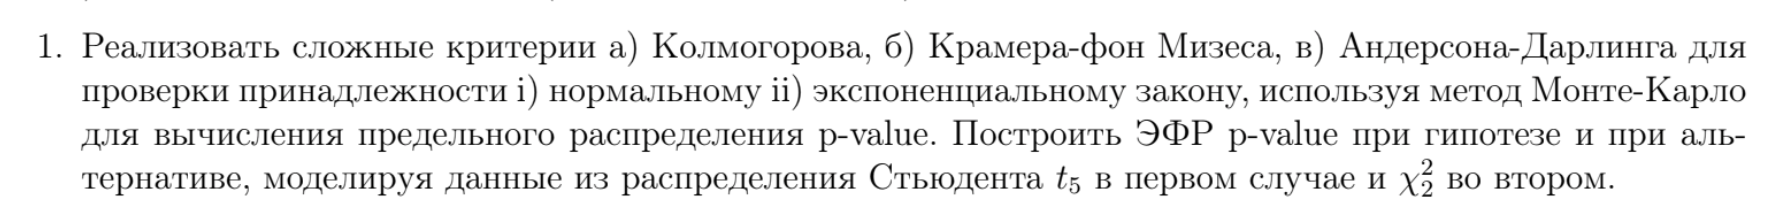

In [2]:
def monte_carlo_test(data, statistic):
    size = len(data)
    pvalue = (data>statistic).sum()/size
    return pvalue

In [3]:
# file = open('ksstat.txt', 'w')
# num_samp = 10000
# size_samp = 2000
# data = sts.expon(loc=0, scale=1).rvs(size=(num_samp,size_samp))
# for i in range(num_samp):
#     print(np.sqrt(size_samp)*sts.kstest(data[i]/(data[i].mean()), sts.expon.cdf).statistic, file = file)
# file.close()

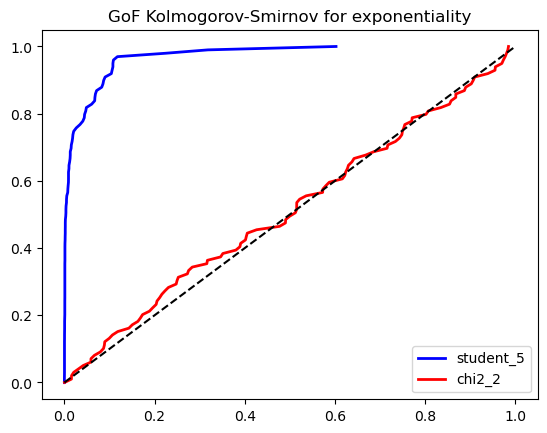

In [54]:
fig, ax = plt.subplots()
plt.title("GoF Kolmogorov-Smirnov for exponentiality")
division_rate = 100
file = open('ksstat.txt', 'r')
data = file.read().splitlines()
file.close()
data = list(map(float, data))
ss = 500
test_t = np.abs(sts.t.rvs(size=(division_rate, ss), df=5))
test_chi2 = sts.chi2.rvs(size=(division_rate, ss), df=2)
def get_res_kolm(sample):
    stat = [np.sqrt(ss)*sts.kstest(sample[i]/(sample[i].mean()), sts.expon.cdf).statistic for i  in range(division_rate)]
    result = np.sort(list(map(lambda x: monte_carlo_test(data, x), stat)))
    return result
y = np.linspace(0,1, division_rate)
ax.plot(get_res_kolm(test_t), y, lw = 2, label = "student_5", color = 'blue')
ax.plot(get_res_kolm(test_chi2), y, lw = 2, label = "chi2_2", color = 'red')
ax.plot(y,y, linestyle='dashed', c='black')
ax.legend()

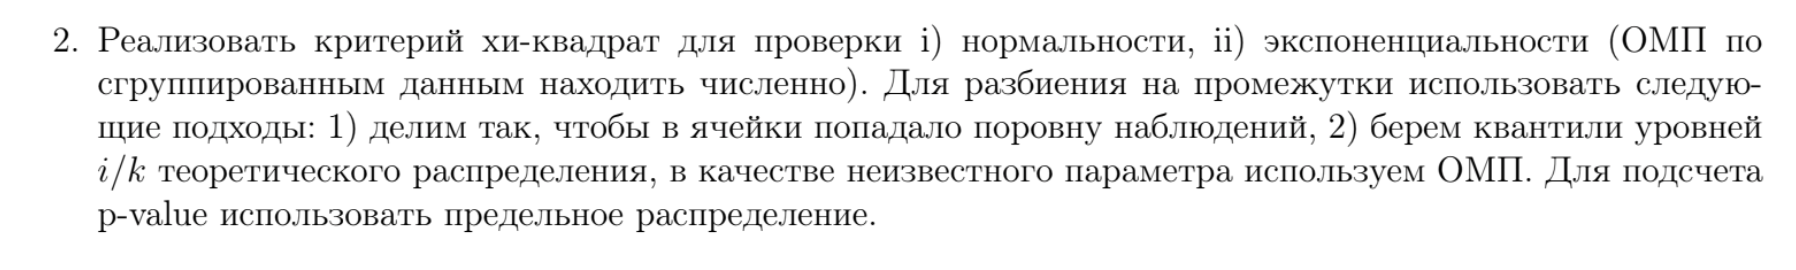

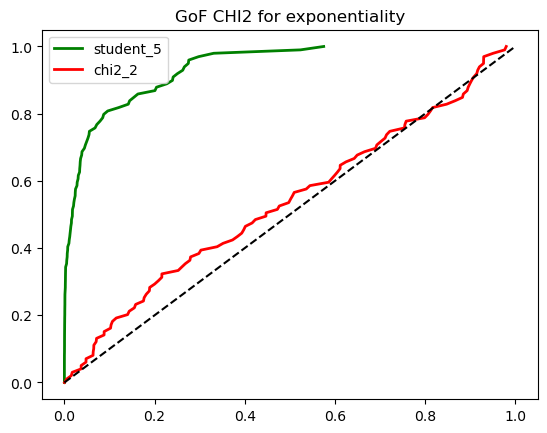

In [3]:
############# разбиение из пункта 1) 
def mle(data, sizes, corners):
    return minimize(likelihood, x0=2, args=(data,sizes,corners), bounds=[(0, None)]).x[0]
fig, ax = plt.subplots()
plt.title("GoF CHI2 for exponentiality")
ss = 500
df = math.floor(math.log2(ss))
division_rate = 100
test_t = np.abs(sts.t.rvs(size=(division_rate, ss), df=5))
test_chi2 = sts.chi2.rvs(size=(division_rate, ss), df=2)
def likelihood(x, sample, sizes, corners):
    result = 0
    for j in range(df):
        if (j==0):
            result += sizes[j]*np.log(1e-4 + sts.expon(scale = x).cdf(corners[j]))
        elif (j==df-1):
            result += sizes[j]*np.log(1e-4 + 1 - sts.expon(scale = x).cdf(corners[j-1]))
        else: 
            result += sizes[j]*np.log(1e-4 + sts.expon(scale = x).cdf(corners[j]) - sts.expon(scale = x).cdf(corners[j-1]))
    return -result
def pval_chi2(sample):
    z = np.array_split(np.sort(sample), df)
    sizes = [len(z[i]) for i in range(df)]
    corners = [z[i][len(z[i])-1] for i in range(df-1)]
    scale_mle = mle(sample, sizes, corners)
    probs = []
    for j in range(df):
        if (j==0):
            probs.append(sts.expon(scale = scale_mle).cdf(corners[j]))
        elif (j==df-1):
            probs.append(1 - sts.expon(scale = scale_mle).cdf(corners[j-1]))
        else: 
            probs.append(sts.expon(scale = scale_mle).cdf(corners[j]) - sts.expon(scale = scale_mle).cdf(corners[j-1]))
    f_exp = ss*np.array(probs)
    result = sts.chisquare(f_exp = f_exp, f_obs=sizes, ddof = 1).pvalue
    return result
y = np.linspace(0,1, division_rate)
res_t = np.sort([pval_chi2(test_t[i]) for i in range(division_rate)])
res_chi = np.sort([pval_chi2(test_chi2[i]) for i in range(division_rate)])
ax.plot(res_t, y, lw = 2, label = "student_5", color = 'green')
ax.plot(res_chi, y, lw = 2, label = "chi2_2", color = 'red')
ax.plot(y,y, linestyle='dashed', c='black')
ax.legend()

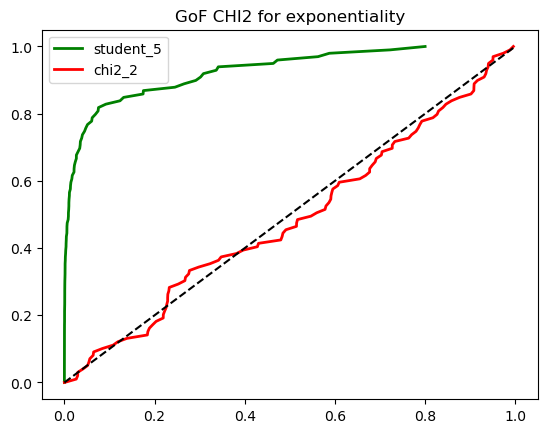

In [6]:
############# разбиение из пункта 2)
def mle(data, sizes, corners):
    return minimize(likelihood, x0=2, args=(data,sizes,corners), bounds=[(0, None)]).x[0]
def get_percentiles(mle_scale, division):
    percentiles = []
    percentiles.append(-float("inf"))
    for j in division:
        percentiles.append(sts.expon(scale=mle_scale).ppf(j))
    percentiles.append(float("inf"))
    return percentiles
fig, ax = plt.subplots()
plt.title("GoF CHI2 for exponentiality")
ss = 500
df = math.floor(math.log2(ss))
def likelihood(x, sample, sizes, corners):
    result = 0
    for j in range(df):
        if (j==0):
            result += sizes[j]*np.log(1e-4 + sts.expon(scale = x).cdf(corners[j]))
        elif (j==df-1):
            result += sizes[j]*np.log(1e-4 + 1 - sts.expon(scale = x).cdf(corners[j-1]))
        else: 
            result += sizes[j]*np.log(1e-4 + sts.expon(scale = x).cdf(corners[j]) - sts.expon(scale = x).cdf(corners[j-1]))
    return -result
division_rate = 100
division = np.arange(1,df,1)/df
test_t = np.abs(sts.t.rvs(size=(division_rate, ss), df=5))
test_chi2 = sts.chi2.rvs(size=(division_rate, ss), df=2)
def pval_chi2(sample):
    scale = sample.mean()
    percentiles = get_percentiles(scale, division)
    sizes = pd.cut(sample, bins=percentiles).value_counts().to_list()
    corners = percentiles[1:df]
    scale_mle = mle(sample, sizes, corners)
    probs = []
    for j in range(df):
        if (j==0):
            probs.append(sts.expon(scale = scale_mle).cdf(corners[j]))
        elif (j==df-1):
            probs.append(1 - sts.expon(scale = scale_mle).cdf(corners[j-1]))
        else: 
            probs.append(sts.expon(scale = scale_mle).cdf(corners[j]) - sts.expon(scale = scale_mle).cdf(corners[j-1]))
    f_exp = ss*np.array(probs)
    result = sts.chisquare(f_exp = f_exp, f_obs=sizes, ddof = 1).pvalue
    return result
y = np.linspace(0,1, division_rate)
res_t = np.sort([pval_chi2(test_t[i]) for i in range(division_rate)])
res_chi = np.sort([pval_chi2(test_chi2[i]) for i in range(division_rate)])

ax.plot(res_t, y, lw = 2, label = "student_5", color = 'green')
ax.plot(res_chi, y, lw = 2, label = "chi2_2", color = 'red')
ax.plot(y,y, linestyle='dashed', c='black')
ax.legend()

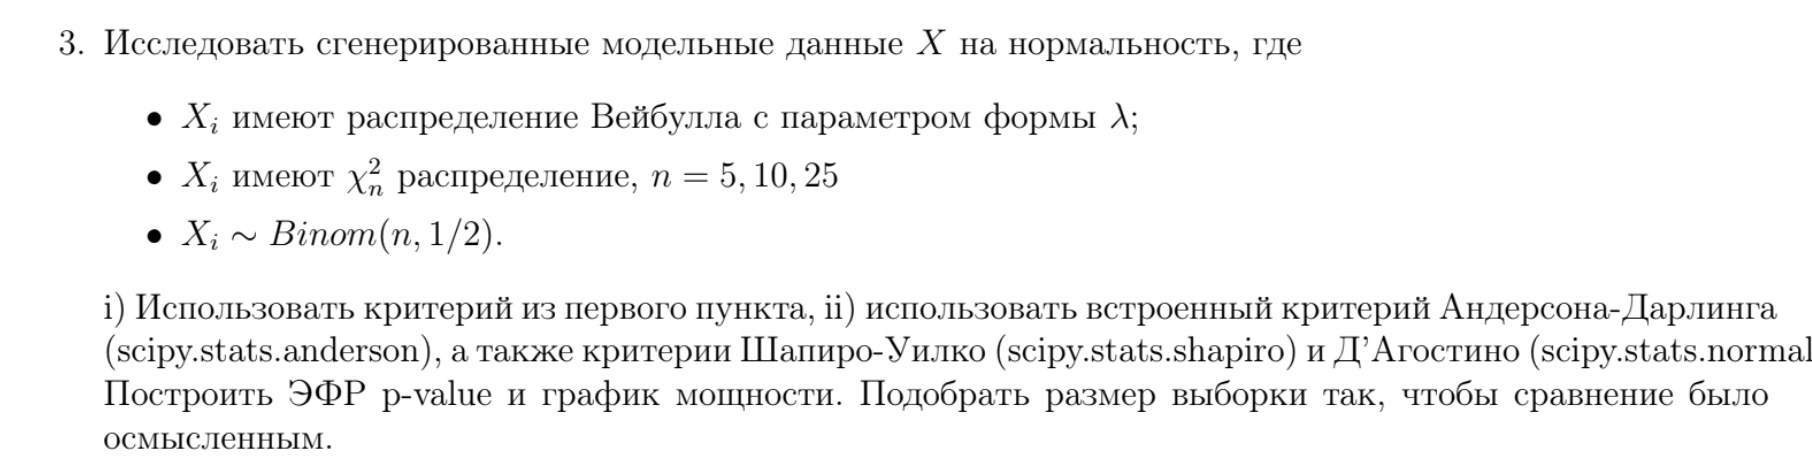

In [6]:
file = open('ad_gof.txt', 'w')
num_samp = 10000
size_samp = 2000
data = sts.norm(loc=0, scale=1).rvs(size=(num_samp,size_samp))
for i in range(num_samp):
    print(sts.anderson((data[i]-data[i].mean())/data[i].std()).statistic, file = file)
file.close()

In [7]:
file = open('ad_gof.txt', 'r')
data = file.read().splitlines()
file.close()
data = list(map(float, data))
division_rate = 100
ss = 50
alpha = 0.05
def task(distr, name, param):
    if distr == sts.weibull_min:
        test_param = np.linspace(0.1,20,50)
        example = distr(param)
    elif distr == sts.chi2:
        test_param = np.arange(1, 50, 1)
        example = distr(param)
    elif distr == sts.binom:
        distr = lambda x: sts.binom(x, p = 1/2)
        test_param = np.arange(5,250,5)
        example = distr(param)
    sample = example.rvs(size=(division_rate, ss))
    fig, ax = plt.subplots(1,2)
    plt.suptitle(name)
    stat1 = [sts.anderson((sample[i]-sample[i].mean())/sample[i].std()).statistic for i  in range(division_rate)]
    result1 = np.sort(list(map(lambda x: monte_carlo_test(data, x), stat1)))
    result2 = np.sort([sts.shapiro(sample[i]).pvalue for i  in range(division_rate)])
    result3 = np.sort([sts.normaltest(sample[i]).pvalue for i  in range(division_rate)])
    y = np.linspace(0,1, division_rate)
    ax[0].set_title("p-value ECDF")
    ax[0].plot(result1, y, lw = 2, label = "AD")
    ax[0].plot(result2, y, lw = 2, label = "SW")
    ax[0].plot(result3, y, lw = 2, label = "DA")
    ax[0].plot(y,y, linestyle='dashed', c='black')
    ax[0].legend()
    fig.tight_layout()
    power1 = []
    power2 = []
    power3 = []
    for param in test_param:
        sample = distr(param).rvs(size=(division_rate, ss))
        stat1 = [sts.anderson((sample[i]-sample[i].mean())/sample[i].std()).statistic for i  in range(division_rate)]
        result1 = np.sort(list(map(lambda x: monte_carlo_test(data, x), stat1)))
        result2 = np.sort([sts.shapiro(sample[i]).pvalue for i  in range(division_rate)])
        result3 = np.sort([sts.normaltest(sample[i]).pvalue for i  in range(division_rate)])
         
        check1= np.array(result1) < alpha
        power1.append(sum(check1)/division_rate)
        
        check2= np.array(result2) < alpha
        power2.append(sum(check2)/division_rate)
        
        check3= np.array(result3) < alpha
        power3.append(sum(check3)/division_rate)

    ax[1].set_title("Power")
    ax[1].plot(test_param, power1, lw = 2, label = "AD")
    ax[1].plot(test_param, power2, lw = 2, label = "SW")
    ax[1].plot(test_param, power3, lw = 2, label = "DA")
    ax[1].legend()

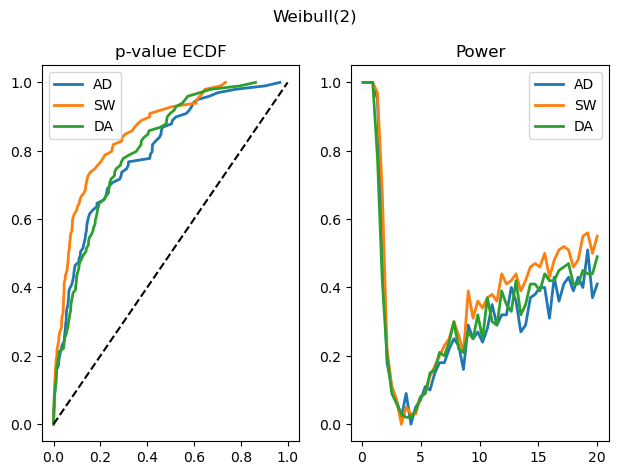

In [8]:
lambda_ = 2
name = f"Weibull({lambda_})"
task(sts.weibull_min, name, lambda_)

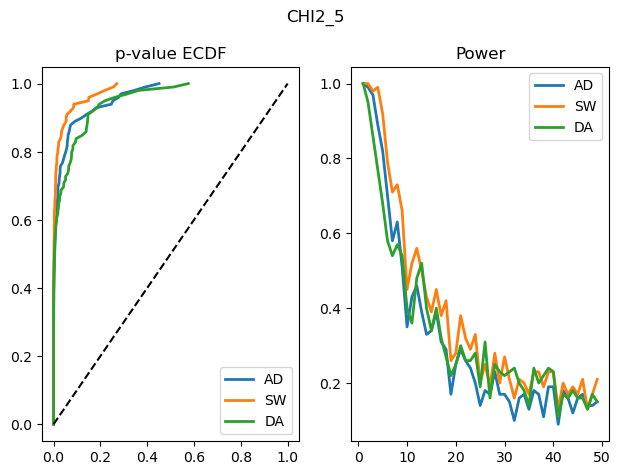

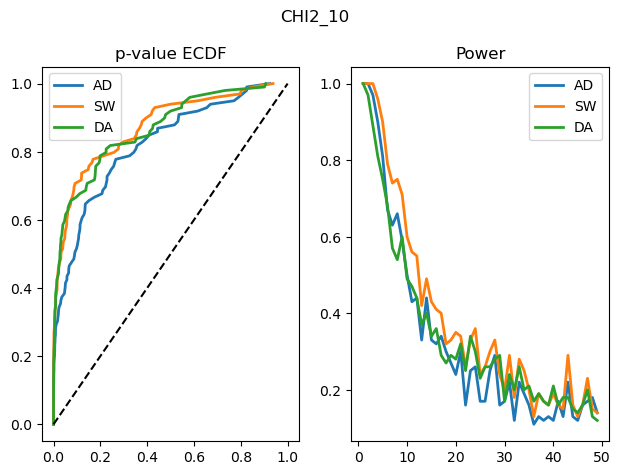

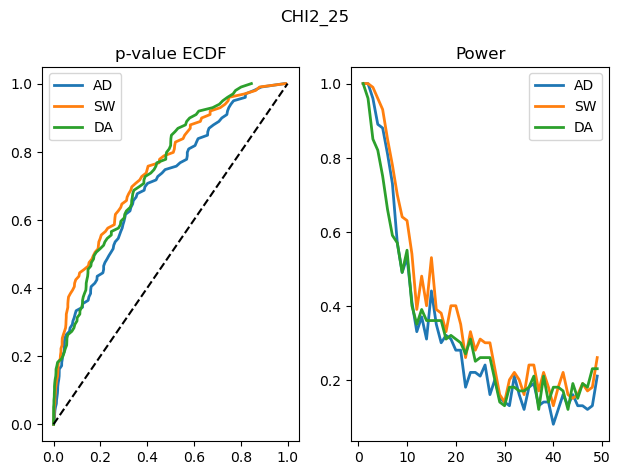

In [9]:
for df in [5,10,25]:
    name = f"CHI2_{df}"
    task(sts.chi2, name, df)

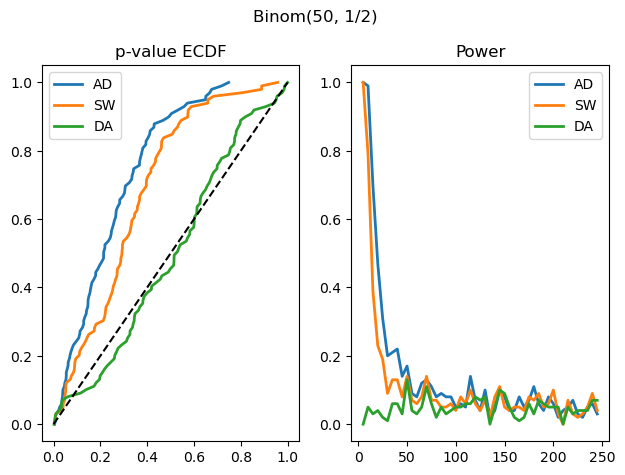

In [10]:
n_test = 50
name = f"Binom({n_test}, 1/2)"
task(sts.binom, name, n_test)

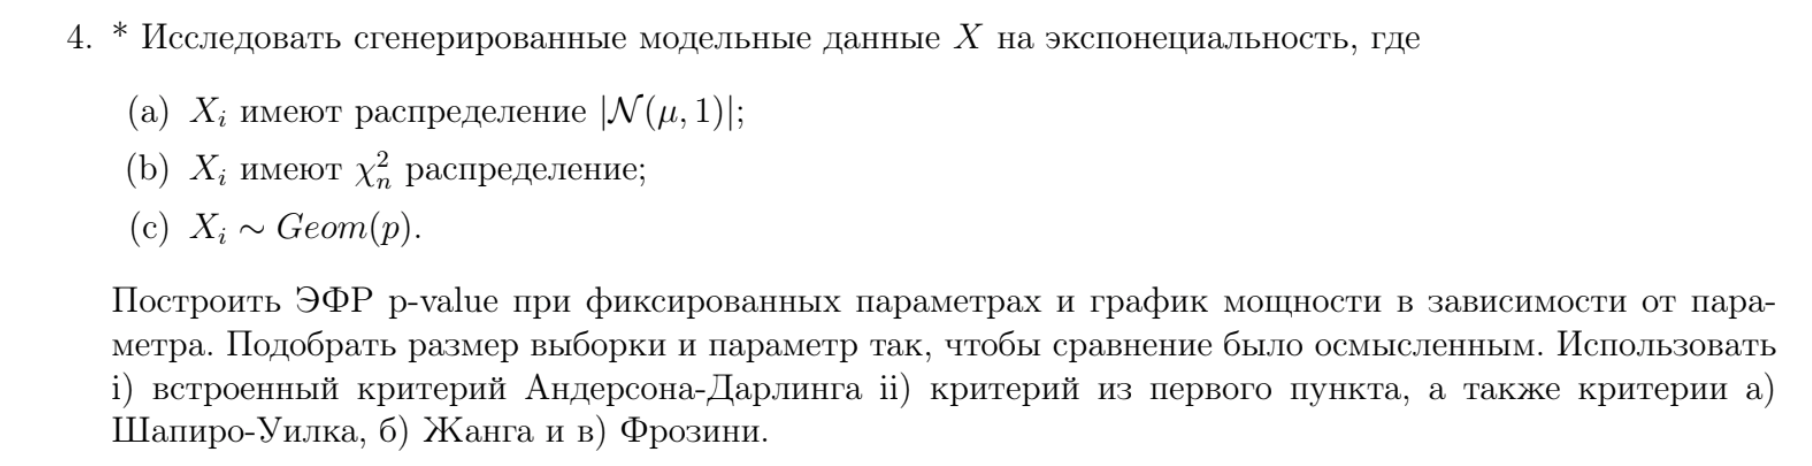

In [58]:
def shapiro_stat(data:np.array):
    size = len(data)
    data.sort()
    mean = data.mean()
    num = (data[0]-mean)**2 * size
    den = (size-1)*(sum((data-mean)**2))+1e-4
    stat = num/den
    return stat

In [59]:
def get_shapiro_pvals(data): #data is 2darray
    num_samp = 10000
    num_given_samp = len(data)
    ss = len(data[0]) # assuming equal sizes of samples in data
    rvs = sts.expon(loc=0, scale=1).rvs(size=(num_samp,ss))
    test_results = [shapiro_stat(rvs[i]) for i  in range(num_samp)]
    data_results = [shapiro_stat(data[i]) for i  in range(num_given_samp)]
    pvals = np.sort(list(map(lambda x: monte_carlo_test(test_results, x), data_results)))
    return pvals

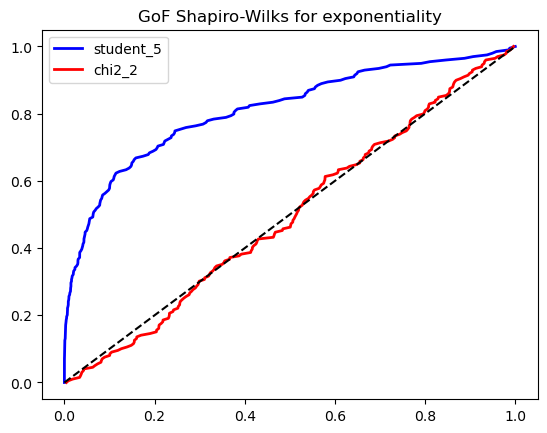

In [61]:
fig, ax = plt.subplots()
plt.title("GoF Shapiro-Wilks for exponentiality")
division_rate = 200
ss = 200
test_t = np.abs(sts.t.rvs(size=(division_rate, ss), df=5))
test_chi2 = sts.chi2.rvs(size=(division_rate, ss), df=2)
y = np.linspace(0,1, division_rate)
ax.plot(get_shapiro_pvals(test_t), y, lw = 2, label = "student_5", color = 'blue')
ax.plot(get_shapiro_pvals(test_chi2), y, lw = 2, label = "chi2_2", color = 'red')
ax.plot(y,y, linestyle='dashed', c='black')
ax.legend()

In [14]:
file = open('ksstat.txt', 'r')
data1 = file.read().splitlines()
file.close()
data1 = list(map(float, data1))
division_rate = 100
alpha = 0.05
def task4(distr, name, param, ss):
    if distr == sts.foldnorm:
        test_param = np.linspace(0,1,20)
        example = distr(param)
    elif distr == sts.chi2:
        test_param = np.arange(1, 50, 1)
        example = distr(param)
    elif distr == sts.geom:
        test_param = np.linspace(0.01,0.99,20)
        example = distr(param)
    sample = example.rvs(size=(division_rate, ss))
    fig, ax = plt.subplots(1,2)
    plt.suptitle(name)
    stat1 = [np.sqrt(ss)*sts.kstest(sample[i]/(sample[i].mean()), sts.expon.cdf).statistic for i  in range(division_rate)]
    result1 = np.sort(list(map(lambda x: monte_carlo_test(data1, x), stat1))) # это я достану колмогорова
    result2 = get_shapiro_pvals(sample)
    y = np.linspace(0,1, division_rate)
    ax[0].set_title("p-value ECDF")
    ax[0].plot(result1, y, lw = 2, label = "KOLM")
    ax[0].plot(result2, y, lw = 2, label = "SW")
    ax[0].plot(y,y, linestyle='dashed', c='black')
    ax[0].legend()
    fig.tight_layout()
    power1 = []
    power2 = []
    for param in test_param:
        sample = distr(param).rvs(size=(division_rate, ss))
        stat1 = [np.sqrt(ss)*sts.kstest(sample[i]/(sample[i].mean()), sts.expon.cdf).statistic for i  in range(division_rate)]
        result1 = np.sort(list(map(lambda x: monte_carlo_test(data1, x), stat1)))
        result2 = get_shapiro_pvals(sample)
    
        check1= np.array(result1) < alpha
        power1.append(sum(check1)/division_rate)
        
        check2= np.array(result2) < alpha
        power2.append(sum(check2)/division_rate)

    ax[1].set_title("Power")
    ax[1].plot(test_param, power1, lw = 2, label = "KOLM")
    ax[1].plot(test_param, power2, lw = 2, label = "SW")
    ax[1].legend()

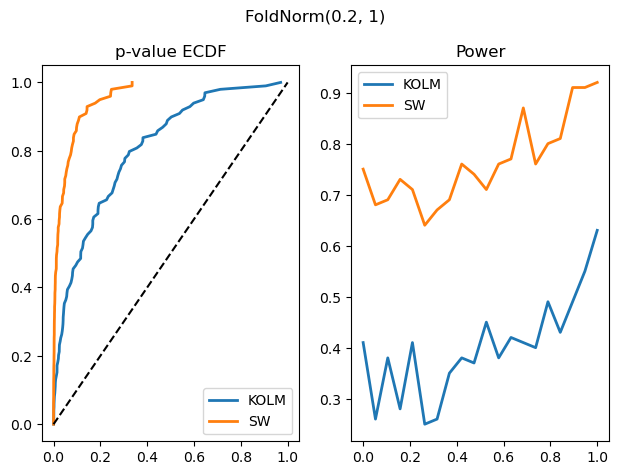

In [15]:
mu_test = 0.2
name = f"FoldNorm({mu_test}, 1)"
task4(sts.foldnorm, name, mu_test, 50)

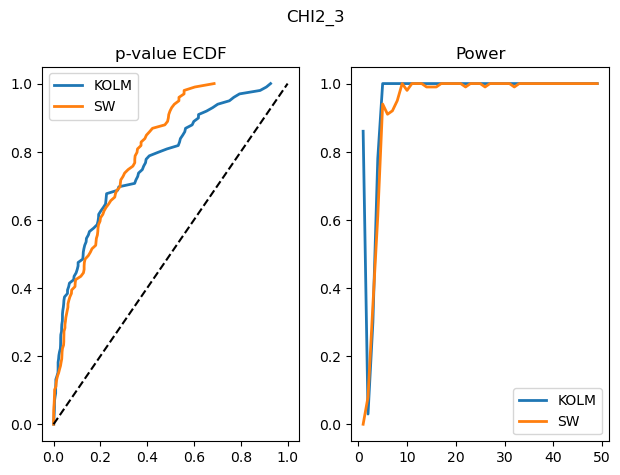

In [16]:
df_test = 3
name = f"CHI2_{df_test}"
task4(sts.chi2, name, df_test, 50)

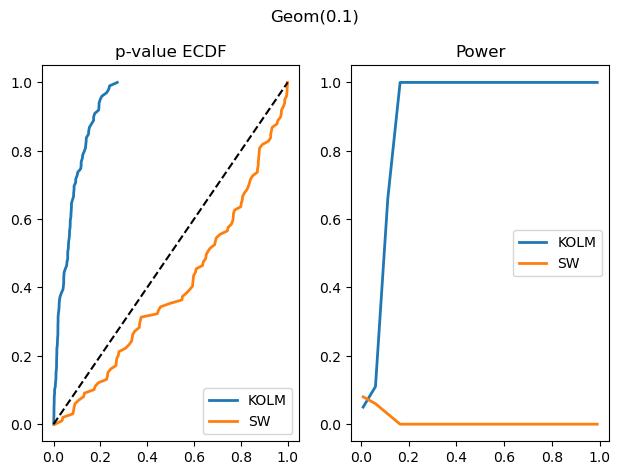

In [17]:
p_test = 0.1
name = f"Geom({p_test})"
task4(sts.geom, name, p_test, 100)